In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import requests
from urllib.parse import urlparse, quote
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False})

In [2]:
park_seoul = pd.read_csv('./data/서울시 주요 공원현황.csv', sep=',', encoding='cp949', index_col='공원번호')
park_seoul.head(1)

,공원명,공원개요,면적,개원일,주요시설,주요식물,안내도,오시는길,이용시참고사항,이미지,지역,공원주소,관리부서,전화번호,X좌표(GRS80TM),Y좌표(GRS80TM),X좌표(WGS84),Y좌표(WGS84),바로가기
공원번호,,,,,,,,,,,,,,,,,,,
1,남산도시자연공원,남산공원은 도심에 위치하여 서울시민에게 맑은 공기를 제공하는 자연휴식처이며 산책 꽃...,2896887㎡ 임 야 : 2454140㎡ 녹지대 및 기타시설 : 442747㎡,1968.9.10,기반시설 : 광장 45950㎡ 도로 108530㎡ 산책로 6.7㎞ (북측:3.7㎞/...,소나무 단풍 아카시아 상수리나무 등 191종 2881870주,http://parks.seoul.go.kr/upload/seditorMulti/2...,명동역(남산케이블카 와룡묘 서울애니메이션센터 방면) 도보 명동역 3번출구 → 퍼시픽...,남산공원 차량통행 금지안내 2005년 5월 1일부터 남산공원에 일반승용차 택시 통행...,http://parks.seoul.go.kr/file/info/view.do?fId...,중구,서울특별시 중구 삼일대로 231(예장동),서울특별시중부푸른도시사업소,02-3783-5900,198364.107,450395.554,126.990377,37.55014,http://parks.seoul.go.kr/template/sub/namsan.do


In [3]:
park_seoul = park_seoul[['공원명', '면적', '지역', '공원주소', '전화번호', 'X좌표(WGS84)', 'Y좌표(WGS84)']]
park_seoul.tail()

,공원명,면적,지역,공원주소,전화번호,X좌표(WGS84),Y좌표(WGS84)
공원번호,,,,,,,
1378,용마도시자연공원(사가정공원),109635㎡,중랑구,서울특별시 중랑구 면목7동 산50,02-2094-2993,127.095997,37.579762
1379,문화비축기지,140022㎡,마포구,서울특별시 마포구 증산로 87,02-376-8410,126.893245,37.571718
1380,경춘선숲길,211392㎡,NaN,노원구 공릉2동 산 82-2,02-2289-4012,127.076482,37.627077
1381,율현공원,157535㎡,강남구,서울특별시 강남구 율현동 밤고개로24길(율현동 56),02-459-9452,127.115594,37.472332
1382,서울로7017,NaN,중구,서울로7017,02-313-7017,NaN,NaN


In [4]:
key_fd = open('kakaomapkey.txt', mode='r')
kmap_key = key_fd.read(100)
key_fd.close()

In [5]:
park_seoul['공원명'][1]

'남산도시자연공원'

In [6]:
url = 'https://dapi.kakao.com/v2/local/geo/coord2address.json?' + 'x=127.095997&y=37.579762'
result = requests.get(url,
        headers={"Authorization": "KakaoAK "+kmap_key}).json()
result['documents'][0]['address']['address_name']

'서울 중랑구 면목동 산 50-23'

In [7]:
url = 'https://dapi.kakao.com/v2/local/geo/coord2address.json?' + 'x=37.579762&y=127.095997'
result = requests.get(url,
        headers={"Authorization": "KakaoAK "+kmap_key}).json()
result

{'meta': {'total_count': 0}, 'documents': []}

In [8]:
# 주소바꾸기
new_addr = []
for i in park_seoul.index:
    try:
        # 2차시도 : 공원명으로검색
        url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query=' + f'서울 {quote(park_seoul["지역"][i])} {quote(park_seoul["공원명"][i])}'
        result = requests.get(url,
                headers={"Authorization": "KakaoAK "+kmap_key}).json()
        addr = result['documents'][0]['address_name']
        new_addr.append(addr)
    except:
        try:
            # 1차시도 : 주소로검색
            url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + quote(park_seoul["공원주소"][i])
            result = requests.get(url,
                    headers={"Authorization": "KakaoAK "+kmap_key}).json()
            addr = result['documents'][0]['address_name']
            new_addr.append(addr)
        except:
            try:
                # 3차시도 : 좌표로 검색
                url = "https://dapi.kakao.com/v2/local/geo/coord2address.json?" + f'x={park_seoul["X좌표(WGS84)"][i]}&y={park_seoul["Y좌표(WGS84)"][i]}&input_coord=WGS84'
                result = requests.get(url,
                        headers={"Authorization": "KakaoAK "+kmap_key}).json()
                addr = result['documents'][0]['address']['address_name']
                new_addr.append(addr)
            except:
                print(i, park_seoul['공원명'][i])

In [9]:
# 구 또는 시로 뽑아내기
addr_list = []
for i in range(len(new_addr)):
    addr = new_addr[i].split(' ')[1]
    addr_list.append(addr)
len(addr_list)

132

In [10]:
park_seoul.head(10)

,공원명,면적,지역,공원주소,전화번호,X좌표(WGS84),Y좌표(WGS84)
공원번호,,,,,,,
1,남산도시자연공원,2896887㎡ 임 야 : 2454140㎡ 녹지대 및 기타시설 : 442747㎡,중구,서울특별시 중구 삼일대로 231(예장동),02-3783-5900,126.990377,37.550140
3,길동생태공원,80683㎡,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),02-489-2770,127.154779,37.540394
4,서울대공원,9132690m²,과천시,경기도 과천시 대공원광장로 102,02-500-7032,127.019847,37.426449
5,서울숲,480994㎡,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),02-460-2905,127.041798,37.543072
6,월드컵공원,2284085㎡,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),02-300-5500,126.878907,37.571805
12,광화문시민열린마당,8948.1㎡,종로구,서울특별시 종로구 세종로 76-2,02-2148-2843,126.978023,37.575045
13,진관근린공원(구파발폭포),휴양 및 편익시설 : 평의자 7개 화장실 23.18㎡ 조경시설 - 은하폭포(높이 1...,은평구,서울특별시 은평구 진관동 393,02-351-8004,126.919216,37.637024
16,중마루근린공원,6456㎥,영등포구,서울특별시 영등포구 영등포동2가 222,02-2670-3717,126.911267,37.519832
17,응봉공원,80309㎡ 배수지 시설용량 : 201.000㎥ 송수 펌프용량 : 직송급수계통 30...,성동구,서울특별시 성동구 금호동1가 산1-72,02-2293-7646,127.021765,37.557228


In [11]:
# 지역내용 바꾸기
park_seoul['지역2'] = addr_list
park_seoul.tail()

,공원명,면적,지역,공원주소,전화번호,X좌표(WGS84),Y좌표(WGS84),지역2
공원번호,,,,,,,,
1378,용마도시자연공원(사가정공원),109635㎡,중랑구,서울특별시 중랑구 면목7동 산50,02-2094-2993,127.095997,37.579762,중랑구
1379,문화비축기지,140022㎡,마포구,서울특별시 마포구 증산로 87,02-376-8410,126.893245,37.571718,마포구
1380,경춘선숲길,211392㎡,NaN,노원구 공릉2동 산 82-2,02-2289-4012,127.076482,37.627077,노원구
1381,율현공원,157535㎡,강남구,서울특별시 강남구 율현동 밤고개로24길(율현동 56),02-459-9452,127.115594,37.472332,강남구
1382,서울로7017,NaN,중구,서울로7017,02-313-7017,NaN,NaN,중구


In [12]:
park_seoul['지역'] = park_seoul['지역'].fillna(park_seoul['지역2'])
park_seoul.tail()

,공원명,면적,지역,공원주소,전화번호,X좌표(WGS84),Y좌표(WGS84),지역2
공원번호,,,,,,,,
1378,용마도시자연공원(사가정공원),109635㎡,중랑구,서울특별시 중랑구 면목7동 산50,02-2094-2993,127.095997,37.579762,중랑구
1379,문화비축기지,140022㎡,마포구,서울특별시 마포구 증산로 87,02-376-8410,126.893245,37.571718,마포구
1380,경춘선숲길,211392㎡,노원구,노원구 공릉2동 산 82-2,02-2289-4012,127.076482,37.627077,노원구
1381,율현공원,157535㎡,강남구,서울특별시 강남구 율현동 밤고개로24길(율현동 56),02-459-9452,127.115594,37.472332,강남구
1382,서울로7017,NaN,중구,서울로7017,02-313-7017,NaN,NaN,중구


In [13]:
del park_seoul['지역2']

In [14]:
# 주소 바꾸기
park_seoul['addr'] = new_addr
park_seoul.tail()

,공원명,면적,지역,공원주소,전화번호,X좌표(WGS84),Y좌표(WGS84),addr
공원번호,,,,,,,,
1378,용마도시자연공원(사가정공원),109635㎡,중랑구,서울특별시 중랑구 면목7동 산50,02-2094-2993,127.095997,37.579762,서울 중랑구 면목동 산 50-23
1379,문화비축기지,140022㎡,마포구,서울특별시 마포구 증산로 87,02-376-8410,126.893245,37.571718,서울 마포구 성산동 661
1380,경춘선숲길,211392㎡,노원구,노원구 공릉2동 산 82-2,02-2289-4012,127.076482,37.627077,서울 노원구 공릉동 425-5
1381,율현공원,157535㎡,강남구,서울특별시 강남구 율현동 밤고개로24길(율현동 56),02-459-9452,127.115594,37.472332,서울 강남구 율현동 77-9
1382,서울로7017,NaN,중구,서울로7017,02-313-7017,NaN,NaN,서울 중구 봉래동2가 122-16


In [15]:
url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query=' + quote('아차산생태공원')
result = requests.get(url,
        headers={"Authorization": "KakaoAK "+kmap_key}).json()
result['documents'][0]

{'address_name': '서울 광진구 광장동 370',
 'category_group_code': '',
 'category_group_name': '',
 'category_name': '여행 > 공원 > 도시근린공원',
 'distance': '',
 'id': '12630966',
 'phone': '02-450-1192',
 'place_name': '아차산생태공원',
 'place_url': 'http://place.map.kakao.com/12630966',
 'road_address_name': '',
 'x': '127.100800735849',
 'y': '37.5517166336474'}

In [16]:
# 좌표바꾸기
lat_list = []; lng_list = []
for i in park_seoul.index:
    try:
        # 1차시도 : 주소로검색
        url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + quote(park_seoul["공원주소"][i])
        result = requests.get(url,
                headers={"Authorization": "KakaoAK "+kmap_key}).json()
        lat = float(result['documents'][0]['y'])
        lng = float(result['documents'][0]['x'])
        lat_list.append(lat)
        lng_list.append(lng)
    except:
        try:
            # 2차시도 : 공원명로검색
            url = 'https://dapi.kakao.com/v2/local/search/keyword.json?query=' + f'서울 {quote(park_seoul["공원명"][i])}'
            result = requests.get(url,
                    headers={"Authorization": "KakaoAK "+kmap_key}).json()
            lat = float(result['documents'][0]['y'])
            lng = float(result['documents'][0]['x'])
            lat_list.append(lat)
            lng_list.append(lng)
        except:
            try:
                # 3차시도 : 새주소로검색
                url = 'https://dapi.kakao.com/v2/local/search/address.json?query=' + quote(park_seoul["addr"][i])
                result = requests.get(url,
                        headers={"Authorization": "KakaoAK "+kmap_key}).json()
                lat = float(result['documents'][0]['y'])
                lng = float(result['documents'][0]['x'])
                lat_list.append(lat)
                lng_list.append(lng)
            except:
                print(i, park_seoul['공원명'][i])

In [17]:
park_seoul['lat']=lat_list; park_seoul['lng']=lng_list
park_seoul.tail()

,공원명,면적,지역,공원주소,전화번호,X좌표(WGS84),Y좌표(WGS84),addr,lat,lng
공원번호,,,,,,,,,,
1378,용마도시자연공원(사가정공원),109635㎡,중랑구,서울특별시 중랑구 면목7동 산50,02-2094-2993,127.095997,37.579762,서울 중랑구 면목동 산 50-23,37.579734,127.096202
1379,문화비축기지,140022㎡,마포구,서울특별시 마포구 증산로 87,02-376-8410,126.893245,37.571718,서울 마포구 성산동 661,37.570347,126.895031
1380,경춘선숲길,211392㎡,노원구,노원구 공릉2동 산 82-2,02-2289-4012,127.076482,37.627077,서울 노원구 공릉동 425-5,37.620692,127.078706
1381,율현공원,157535㎡,강남구,서울특별시 강남구 율현동 밤고개로24길(율현동 56),02-459-9452,127.115594,37.472332,서울 강남구 율현동 77-9,37.471047,127.105459
1382,서울로7017,NaN,중구,서울로7017,02-313-7017,NaN,NaN,서울 중구 봉래동2가 122-16,37.556621,126.970298


In [19]:
del park_seoul['X좌표(WGS84)']
del park_seoul['Y좌표(WGS84)']

In [20]:
park_seoul['공원명'][1378]

'용마도시자연공원(사가정공원)'

In [21]:
# 면적바꾸기 = 면적이 제대로 적혀있지않은것은 nan처리
park_seoul['면적'] = park_seoul['면적'].str.replace(' ', '')
park_seoul['면적'] = park_seoul['면적'].str.replace('총', '')
park_seoul.head()

,공원명,면적,지역,공원주소,전화번호,addr,lat,lng
공원번호,,,,,,,,
1,남산도시자연공원,2896887㎡임야:2454140㎡녹지대및기타시설:442747㎡,중구,서울특별시 중구 삼일대로 231(예장동),02-3783-5900,서울 중구 예장동 산 5-6,37.555633,126.992218
3,길동생태공원,80683㎡,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),02-489-2770,서울 강동구 길동 산 7-3,37.539066,127.153329
4,서울대공원,9132690m²,과천시,경기도 과천시 대공원광장로 102,02-500-7032,경기 과천시 막계동 산 42-1,37.436431,127.014098
5,서울숲,480994㎡,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),02-460-2905,서울 성동구 성수동1가 678-1,37.543070,127.041799
6,월드컵공원,2284085㎡,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),02-300-5500,서울 마포구 성산동 390-1,37.572327,126.881889


In [22]:
park_seoul['면적'] = park_seoul['면적'].str.replace('㎡', ' ')
park_seoul['면적'] = park_seoul['면적'].str.replace('m²', ' ')
park_seoul['면적'] = park_seoul['면적'].str.replace('㎥', ' ')
park_seoul['면적'] = park_seoul['면적'].str.replace('m2', ' ')
park_seoul.head()

,공원명,면적,지역,공원주소,전화번호,addr,lat,lng
공원번호,,,,,,,,
1,남산도시자연공원,2896887 임야:2454140 녹지대및기타시설:442747,중구,서울특별시 중구 삼일대로 231(예장동),02-3783-5900,서울 중구 예장동 산 5-6,37.555633,126.992218
3,길동생태공원,80683,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),02-489-2770,서울 강동구 길동 산 7-3,37.539066,127.153329
4,서울대공원,9132690,과천시,경기도 과천시 대공원광장로 102,02-500-7032,경기 과천시 막계동 산 42-1,37.436431,127.014098
5,서울숲,480994,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),02-460-2905,서울 성동구 성수동1가 678-1,37.543070,127.041799
6,월드컵공원,2284085,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),02-300-5500,서울 마포구 성산동 390-1,37.572327,126.881889


In [23]:
area_list = []
for i in park_seoul.index:
    area = park_seoul['면적'][i]
    area_list.append(area)
print(area_list)

['2896887 임야:2454140 녹지대및기타시설:442747 ', '80683 ', '9132690 ', '480994 ', '2284085 ', '8948.1 ', '휴양및편익시설:평의자7개화장실23.18 조경시설-은하폭포(높이12m×폭10m발원지로부터17.3m폭1.5~10m수조255 담수량140t)-산성폭포(높이5m×폭12m수조90 담수량75t)-명속의벽1개소(높이5.4m)교양시설:야외공연무대102 관리시설:관리실8.55 전기실51.03 기계실83.36 안내판1개공원등18본휴양시설:벤취12개', '6456 ', '80309 배수지시설용량:201.000 송수펌프용량:직송급수계통30000 /일금호배수지계통16400 /일', '1980.4 ', '5197.7 ', '11467 ', '229539 ', '15179.7 ', '16734.60 ', '61544 녹지대:40792 광장:6600 기타:14152 ', '424106 ', '560552 ', '26696.8 ', '75900 ', '113021.7 ', '201779 ', '258991 ', '10420819.08 ', '171294.1 ', '15000 ', '297926 ', '411972 ', '98470 ', '2038741.3 ', '603715.2 ', '108120 ', '29619.3 ', '29843.8 ', '126026 ', '135002.7 ', '384026 ', '180000 ', '416031 ', '160720 ', '2277252 ', '19599.70 ', '138596 ', '185295 ', '254648 ', '29816.5 ', '762642 ', '664905 ', '99599.9 ', '5802 ', '16500 ', '585652 ', '649709.6 ', '72132 ', '66027.8 ', '265582 ', '2088704.9 ', '112070 ', '993724 ', '219167 곰두리체육센터:7370 (지하2층지상3층)송파도서관:8259 (

In [24]:
area_list[1].split()[0]

'80683'

In [25]:
n_area_list = []
for i in range(len(area_list)):
    n_area_list.append(str(area_list[i]).split()[0])
print(n_area_list)

['2896887', '80683', '9132690', '480994', '2284085', '8948.1', '휴양및편익시설:평의자7개화장실23.18', '6456', '80309', '1980.4', '5197.7', '11467', '229539', '15179.7', '16734.60', '61544', '424106', '560552', '26696.8', '75900', '113021.7', '201779', '258991', '10420819.08', '171294.1', '15000', '297926', '411972', '98470', '2038741.3', '603715.2', '108120', '29619.3', '29843.8', '126026', '135002.7', '384026', '180000', '416031', '160720', '2277252', '19599.70', '138596', '185295', '254648', '29816.5', '762642', '664905', '99599.9', '5802', '16500', '585652', '649709.6', '72132', '66027.8', '265582', '2088704.9', '112070', '993724', '219167', '1349556.4', '1511198', '1097565', '328018', '1447122', '207790', '1018689', '954553', '1667848', '13224', '130345', '5332422', '5107964', '47832', '213552', '168099.87', '359435.2', '36660', '380735', '1807420.9', '359342.8', '632733', '328018', '6691885.3', '285757', '110407', '29682.2', '137759', '917190', '51470', '662543', '217946', '179666', '34955', '1

In [26]:
n2_area_list=[]
for n in range(len(n_area_list)):
    if len(n_area_list[n]) > 15:
        n2_area_list.append(np.nan)
    else:
        n2_area_list.append(n_area_list[n])
print(n2_area_list)

['2896887', '80683', '9132690', '480994', '2284085', '8948.1', nan, '6456', '80309', '1980.4', '5197.7', '11467', '229539', '15179.7', '16734.60', '61544', '424106', '560552', '26696.8', '75900', '113021.7', '201779', '258991', '10420819.08', '171294.1', '15000', '297926', '411972', '98470', '2038741.3', '603715.2', '108120', '29619.3', '29843.8', '126026', '135002.7', '384026', '180000', '416031', '160720', '2277252', '19599.70', '138596', '185295', '254648', '29816.5', '762642', '664905', '99599.9', '5802', '16500', '585652', '649709.6', '72132', '66027.8', '265582', '2088704.9', '112070', '993724', '219167', '1349556.4', '1511198', '1097565', '328018', '1447122', '207790', '1018689', '954553', '1667848', '13224', '130345', '5332422', '5107964', '47832', '213552', '168099.87', '359435.2', '36660', '380735', '1807420.9', '359342.8', '632733', '328018', '6691885.3', '285757', '110407', '29682.2', '137759', '917190', '51470', '662543', '217946', '179666', '34955', '18083', '4835', '1965

In [27]:
park_seoul['면적'] = n2_area_list
park_seoul.tail()

,공원명,면적,지역,공원주소,전화번호,addr,lat,lng
공원번호,,,,,,,,
1378,용마도시자연공원(사가정공원),109635,중랑구,서울특별시 중랑구 면목7동 산50,02-2094-2993,서울 중랑구 면목동 산 50-23,37.579734,127.096202
1379,문화비축기지,140022,마포구,서울특별시 마포구 증산로 87,02-376-8410,서울 마포구 성산동 661,37.570347,126.895031
1380,경춘선숲길,211392,노원구,노원구 공릉2동 산 82-2,02-2289-4012,서울 노원구 공릉동 425-5,37.620692,127.078706
1381,율현공원,157535,강남구,서울특별시 강남구 율현동 밤고개로24길(율현동 56),02-459-9452,서울 강남구 율현동 77-9,37.471047,127.105459
1382,서울로7017,nan,중구,서울로7017,02-313-7017,서울 중구 봉래동2가 122-16,37.556621,126.970298


In [28]:
nan_index = []
for n in park_seoul.index:
    if park_seoul['면적'][n] == 'nan':
        print(park_seoul['공원명'][n])
        nan_index.append(n)
nan_index

푸른수목원
문화역 서울284
서울로7017


[1348, 1370, 1382]

In [29]:
park_seoul['면적'][13]

nan

In [30]:
park_seoul['면적'][13] = 983.791
park_seoul['면적'][1348] = 103354
park_seoul['면적'][1370] = 2964.6
park_seoul['면적'][1382] = 22862

park_seoul.tail()

,공원명,면적,지역,공원주소,전화번호,addr,lat,lng
공원번호,,,,,,,,
1378,용마도시자연공원(사가정공원),109635,중랑구,서울특별시 중랑구 면목7동 산50,02-2094-2993,서울 중랑구 면목동 산 50-23,37.579734,127.096202
1379,문화비축기지,140022,마포구,서울특별시 마포구 증산로 87,02-376-8410,서울 마포구 성산동 661,37.570347,126.895031
1380,경춘선숲길,211392,노원구,노원구 공릉2동 산 82-2,02-2289-4012,서울 노원구 공릉동 425-5,37.620692,127.078706
1381,율현공원,157535,강남구,서울특별시 강남구 율현동 밤고개로24길(율현동 56),02-459-9452,서울 강남구 율현동 77-9,37.471047,127.105459
1382,서울로7017,22862,중구,서울로7017,02-313-7017,서울 중구 봉래동2가 122-16,37.556621,126.970298


In [31]:
park_seoul.tail()

,공원명,면적,지역,공원주소,전화번호,addr,lat,lng
공원번호,,,,,,,,
1378,용마도시자연공원(사가정공원),109635,중랑구,서울특별시 중랑구 면목7동 산50,02-2094-2993,서울 중랑구 면목동 산 50-23,37.579734,127.096202
1379,문화비축기지,140022,마포구,서울특별시 마포구 증산로 87,02-376-8410,서울 마포구 성산동 661,37.570347,126.895031
1380,경춘선숲길,211392,노원구,노원구 공릉2동 산 82-2,02-2289-4012,서울 노원구 공릉동 425-5,37.620692,127.078706
1381,율현공원,157535,강남구,서울특별시 강남구 율현동 밤고개로24길(율현동 56),02-459-9452,서울 강남구 율현동 77-9,37.471047,127.105459
1382,서울로7017,22862,중구,서울로7017,02-313-7017,서울 중구 봉래동2가 122-16,37.556621,126.970298


In [32]:
park_seoul = park_seoul.astype({'면적':'float'})
park_seoul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132 entries, 1 to 1382
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   공원명     132 non-null    object 
 1   면적      132 non-null    float64
 2   지역      132 non-null    object 
 3   공원주소    132 non-null    object 
 4   전화번호    132 non-null    object 
 5   addr    132 non-null    object 
 6   lat     132 non-null    float64
 7   lng     132 non-null    float64
dtypes: float64(3), object(5)
memory usage: 9.3+ KB


In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)

#### 1. 지역별 공원수

In [34]:
num_one = park_seoul.groupby(park_seoul['지역']).count()
num_one.head()

,공원명,면적,공원주소,전화번호,addr,lat,lng
지역,,,,,,,
강남구,7,7,7,7,7,7,7
강동구,7,7,7,7,7,7,7
강북구,4,4,4,4,4,4,4
강서구,9,9,9,9,9,9,9
과천시,1,1,1,1,1,1,1


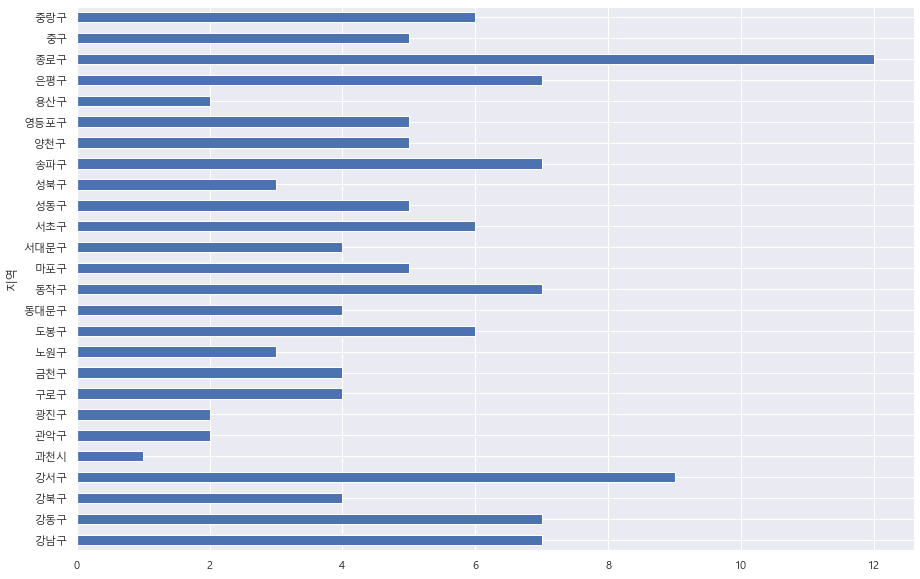

In [35]:
num_one['공원명'].plot(kind='barh', grid=True, figsize=(15,10))
plt.show()

#### 2. 구 인구별 공원 면적

In [36]:
pop_seoul = pd.read_csv('./data/서울시 인구현황.txt', sep='\t', encoding='utf8', header=2)
pop_seoul.head()

,기간,자치구,세대,계,남자,여자,계.1,남자.1,여자.1,계.2,남자.2,여자.2,세대당인구,65세이상고령자
0,2020.3/4,합계,"4,405,833","9,953,009","4,840,912","5,112,097","9,699,232","4,719,170","4,980,062","253,777","121,742","132,035",2.20,"1,552,356"
1,2020.3/4,종로구,"74,861","159,842","77,391","82,451","149,952","73,024","76,928","9,890","4,367","5,523",2.00,"28,396"
2,2020.3/4,중구,"63,594","135,321","66,193","69,128","125,800","61,526","64,274","9,521","4,667","4,854",1.98,"24,265"
3,2020.3/4,용산구,"112,451","244,953","119,074","125,879","229,786","110,604","119,182","15,167","8,470","6,697",2.04,"39,995"
4,2020.3/4,성동구,"136,096","302,695","147,582","155,113","295,591","144,444","151,147","7,104","3,138","3,966",2.17,"45,372"


In [37]:
pop_seoul = pop_seoul.set_index('자치구')
pop_seoul.tail()

,기간,세대,계,남자,여자,계.1,남자.1,여자.1,계.2,남자.2,여자.2,세대당인구,65세이상고령자
자치구,,,,,,,,,,,,,
관악구,2020.3/4,"275,248","514,555","257,638","256,917","498,574","250,084","248,490","15,981","7,554","8,427",1.81,"78,206"
서초구,2020.3/4,"173,483","429,995","205,671","224,324","426,009","203,686","222,323","3,986","1,985","2,001",2.46,"59,495"
강남구,2020.3/4,"234,021","544,085","260,358","283,727","539,235","257,961","281,274","4,850","2,397","2,453",2.30,"73,942"
송파구,2020.3/4,"281,417","676,673","326,602","350,071","670,331","323,646","346,685","6,342","2,956","3,386",2.38,"92,149"
강동구,2020.3/4,"194,602","462,275","227,346","234,929","458,058","225,396","232,662","4,217","1,950","2,267",2.35,"68,798"


In [38]:
pop_seoul2 = pop_seoul[['계']]
pop_seoul2 = pop_seoul2.drop(pop_seoul2.index[0])
pop_seoul2['계'] = pop_seoul2['계'].str.replace(',', '')
pop_seoul2 = pop_seoul2.astype(int)
pop_seoul2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 종로구 to 강동구
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   계       25 non-null     int32
dtypes: int32(1)
memory usage: 300.0+ bytes


In [39]:
sum_park = park_seoul.groupby(park_seoul['지역']).sum()
sum_park = sum_park[['면적']]
sum_park = sum_park.astype(int)
sum_park.head()

,면적
지역,
강남구,3626398
강동구,1526389
강북구,3714902
강서구,2194154
과천시,9132690


In [40]:
b = pd.concat([sum_park, pop_seoul2], axis=1, )
b.head()

,면적,계
강남구,3626398,544085.0
강동구,1526389,462275.0
강북구,3714902,313550.0
강서구,2194154,589536.0
과천시,9132690,NaN


In [41]:
# 과천시(결측값이 생긴 행) 삭제
df2 = b.dropna(axis=0)
df2.head()

,면적,계
강남구,3626398,544085.0
강동구,1526389,462275.0
강북구,3714902,313550.0
강서구,2194154,589536.0
관악구,10431453,514555.0


In [42]:
fp1 = np.polyfit(df2['면적'], df2['계'], 1)
fp1

array([9.61218313e-03, 3.65750421e+05])

In [43]:
fx = np.array([20, 50])
f1 = np.poly1d(fp1)
fy = f1(fx)
fy

array([365750.61355846, 365750.90192396])

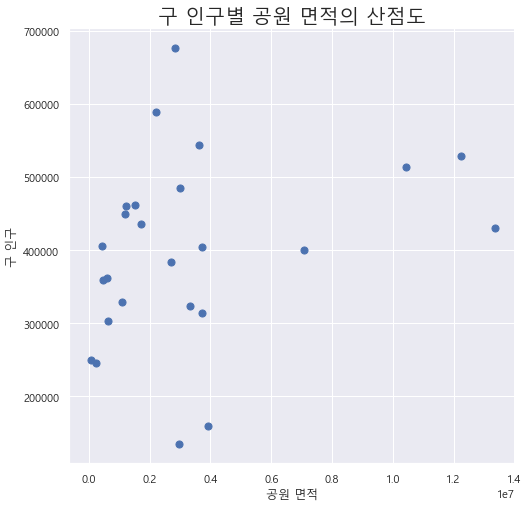

In [44]:
plt.figure(figsize=(8,8))
plt.scatter(df2['면적'], df2['계'], s=50)
plt.plot(fx, fy, ls='dashed', lw=3, color='g')
plt.grid(True)
plt.title('구 인구별 공원 면적의 산점도', fontsize=20)
plt.xlabel('공원 면적')
plt.ylabel('구 인구')
plt.show()

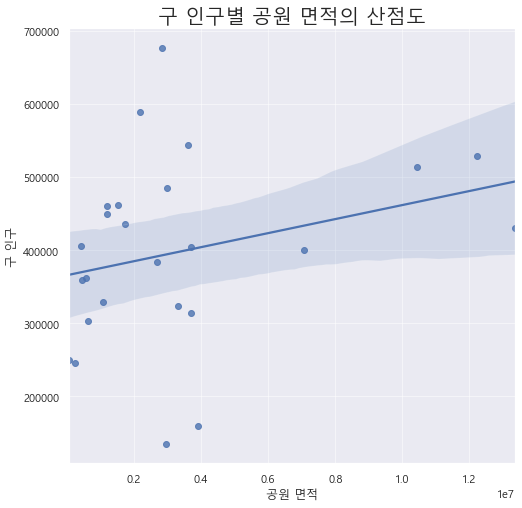

In [45]:
plt.figure(figsize=(8,8))
sns.regplot(x=df2['면적'], y=df2['계'], fit_reg=True)
plt.grid(True, alpha=0.5)
plt.title('구 인구별 공원 면적의 산점도', fontsize=20)
plt.xlabel('공원 면적')
plt.ylabel('구 인구')
plt.show()

### 강사님 ver

In [46]:
b['인당공원면적'] = b['면적'] / b['계']
b.head()

,면적,계,인당공원면적
강남구,3626398,544085.0,6.665131
강동구,1526389,462275.0,3.301907
강북구,3714902,313550.0,11.847878
강서구,2194154,589536.0,3.721832
과천시,9132690,NaN,NaN


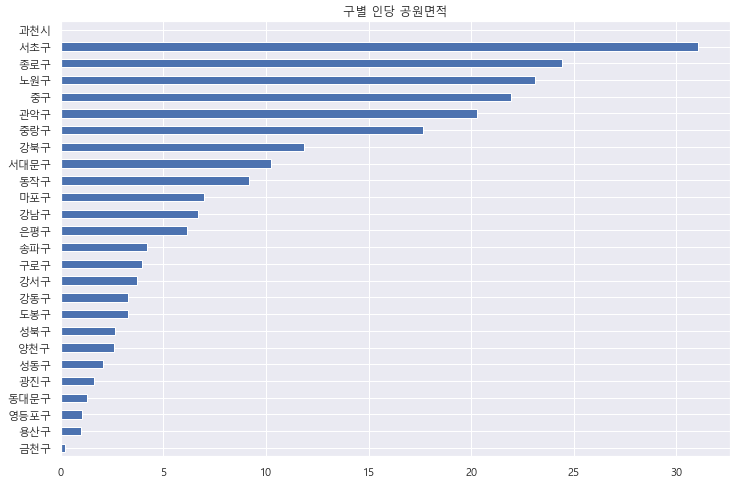

In [47]:
b['인당공원면적'].sort_values().plot(kind='barh', grid=True, figsize=(12,8))
plt.title('구별 인당 공원면적')
plt.show()

#### 3. 공원 면적 vs 구 면적

In [48]:
# 구 면적 데이터(km2)
gu_area = pd.read_csv('./data/서울시 행정구역 (구별) 통계.txt', sep='\t', encoding='utf8', header=1)
gu_area.head()

,기간,자치구,면적,구성비(%),행정,법정,통,반
0,2019,서울시,605.24,100.0,424,467,"12,713","94,152"
1,2019,종로구,23.91,4.0,17,87,278,"1,479"
2,2019,중구,9.96,1.6,15,74,253,"1,580"
3,2019,용산구,21.87,3.6,16,36,351,"2,550"
4,2019,성동구,16.86,2.8,17,17,466,"3,619"


In [49]:
gu_area = gu_area.drop(gu_area.index[0])
gu_area.head()

,기간,자치구,면적,구성비(%),행정,법정,통,반
1,2019,종로구,23.91,4.0,17,87,278,"1,479"
2,2019,중구,9.96,1.6,15,74,253,"1,580"
3,2019,용산구,21.87,3.6,16,36,351,"2,550"
4,2019,성동구,16.86,2.8,17,17,466,"3,619"
5,2019,광진구,17.06,2.8,15,7,363,"2,999"


In [50]:
# 면적을 m2수치로 변환 (*백만)
area_list = []
for area in gu_area.index:
    area_list.append(gu_area['면적'][area])
print(area_list)

[23.91, 9.96, 21.87, 16.86, 17.06, 14.22, 18.5, 24.57, 23.6, 20.66, 35.44, 29.71, 17.63, 23.85, 17.41, 41.44, 20.12, 13.02, 24.55, 16.35, 29.57, 46.98, 39.5, 33.87, 24.59]


In [51]:
k_area_list = []
for k in range(len(area_list)):
    k_area = area_list[k] * 1000000
    k_area_list.append(int(k_area))
print(k_area_list)

[23910000, 9960000, 21870000, 16860000, 17060000, 14220000, 18500000, 24570000, 23600000, 20660000, 35440000, 29710000, 17630000, 23850000, 17410000, 41440000, 20120000, 13020000, 24550000, 16350000, 29570000, 46980000, 39500000, 33870000, 24590000]


In [52]:
gu_area['면적'] = k_area_list
gu_area.head()

,기간,자치구,면적,구성비(%),행정,법정,통,반
1,2019,종로구,23910000,4.0,17,87,278,"1,479"
2,2019,중구,9960000,1.6,15,74,253,"1,580"
3,2019,용산구,21870000,3.6,16,36,351,"2,550"
4,2019,성동구,16860000,2.8,17,17,466,"3,619"
5,2019,광진구,17060000,2.8,15,7,363,"2,999"


In [53]:
gu_area = gu_area.set_index(gu_area['자치구'])
gu_area.head()

,기간,자치구,면적,구성비(%),행정,법정,통,반
자치구,,,,,,,,
종로구,2019,종로구,23910000,4.0,17,87,278,"1,479"
중구,2019,중구,9960000,1.6,15,74,253,"1,580"
용산구,2019,용산구,21870000,3.6,16,36,351,"2,550"
성동구,2019,성동구,16860000,2.8,17,17,466,"3,619"
광진구,2019,광진구,17060000,2.8,15,7,363,"2,999"


In [54]:
gu_area = gu_area.rename(columns = {"면적": "구면적"})
gu_area.head()

,기간,자치구,구면적,구성비(%),행정,법정,통,반
자치구,,,,,,,,
종로구,2019,종로구,23910000,4.0,17,87,278,"1,479"
중구,2019,중구,9960000,1.6,15,74,253,"1,580"
용산구,2019,용산구,21870000,3.6,16,36,351,"2,550"
성동구,2019,성동구,16860000,2.8,17,17,466,"3,619"
광진구,2019,광진구,17060000,2.8,15,7,363,"2,999"


In [55]:
df3 = pd.concat([sum_park, gu_area], axis=1)
df3.head()

,면적,기간,자치구,구면적,구성비(%),행정,법정,통,반
강남구,3626398,2019.0,강남구,39500000.0,6.5,22.0,14.0,836,"5,550"
강동구,1526389,2019.0,강동구,24590000.0,4.1,18.0,9.0,591,"5,192"
강북구,3714902,2019.0,강북구,23600000.0,3.9,13.0,4.0,388,"3,376"
강서구,2194154,2019.0,강서구,41440000.0,6.8,20.0,13.0,644,"5,062"
과천시,9132690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
# 과천시 삭제
df3 = df3.dropna(axis=0)
df3.head()

,면적,기간,자치구,구면적,구성비(%),행정,법정,통,반
강남구,3626398,2019.0,강남구,39500000.0,6.5,22.0,14.0,836,"5,550"
강동구,1526389,2019.0,강동구,24590000.0,4.1,18.0,9.0,591,"5,192"
강북구,3714902,2019.0,강북구,23600000.0,3.9,13.0,4.0,388,"3,376"
강서구,2194154,2019.0,강서구,41440000.0,6.8,20.0,13.0,644,"5,062"
관악구,10431453,2019.0,관악구,29570000.0,4.9,21.0,3.0,631,"5,136"


In [57]:
df4 = df3[['면적', '구면적']]
df4 = df4.rename(columns = {"면적": "공원면적"})
df4.head()

,공원면적,구면적
강남구,3626398,39500000.0
강동구,1526389,24590000.0
강북구,3714902,23600000.0
강서구,2194154,41440000.0
관악구,10431453,29570000.0


In [58]:
fp1 = np.polyfit(df4['공원면적'], df4['구면적'], 1)
fp1

array([1.45482452e+00, 1.93103404e+07])

In [59]:
fx = np.array([20, 50])
f1 = np.poly1d(fp1)
fy = f1(fx)
fy

array([19310369.47740348, 19310413.12213921])

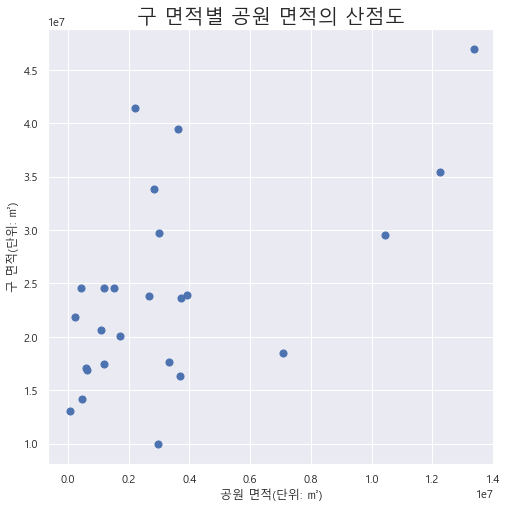

In [60]:
plt.figure(figsize=(8,8))
plt.scatter(df4['공원면적'], df4['구면적'], s=50)
plt.plot(fx, fy, ls='dashed', lw=3, color='g')
plt.grid(True)
plt.title('구 면적별 공원 면적의 산점도', fontsize=20)
plt.xlabel('공원 면적(단위: ㎡)')
plt.ylabel('구 면적(단위: ㎡)')
plt.show()

In [61]:
df4['오차'] = np.abs(df4['구면적'] - f1(df4['공원면적']))
df_sort = df4.sort_values('오차', ascending=False)
df_sort.head()

,공원면적,구면적,오차
강서구,2194154,41440000.0,1.893755e+07
강남구,3626398,39500000.0,1.491389e+07
중구,2969130,9960000.0,1.366990e+07
중랑구,7078975,18500000.0,1.110901e+07
송파구,2838992,33870000.0,1.042942e+07


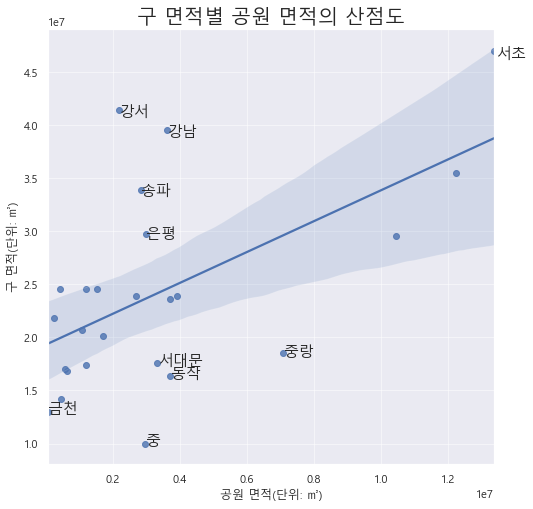

In [62]:
plt.figure(figsize=(8,8))
sns.regplot(x=df4['공원면적'], y=df4['구면적'], fit_reg=True)
plt.grid(True, alpha=0.5)

for i in range(10): 
    plt.text(df_sort['공원면적'][i]*1.005, df_sort['구면적'][i]*0.985,
             df_sort.index[i][:-1], fontsize=15)

plt.title('구 면적별 공원 면적의 산점도', fontsize=20)
plt.xlabel('공원 면적(단위: ㎡)')
plt.ylabel('구 면적(단위: ㎡)')
plt.show()

#### 4. 공원 지도에 표시하기(공원 크기가 차이가 나도록)

In [63]:
import folium

In [64]:
park_seoul.head()

,공원명,면적,지역,공원주소,전화번호,addr,lat,lng
공원번호,,,,,,,,
1,남산도시자연공원,2896887.0,중구,서울특별시 중구 삼일대로 231(예장동),02-3783-5900,서울 중구 예장동 산 5-6,37.555633,126.992218
3,길동생태공원,80683.0,강동구,서울특별시 강동구 천호대로 1291(길동생태공원),02-489-2770,서울 강동구 길동 산 7-3,37.539066,127.153329
4,서울대공원,9132690.0,과천시,경기도 과천시 대공원광장로 102,02-500-7032,경기 과천시 막계동 산 42-1,37.436431,127.014098
5,서울숲,480994.0,성동구,서울특별시 성동구 뚝섬로 273 (성수동1가),02-460-2905,서울 성동구 성수동1가 678-1,37.543070,127.041799
6,월드컵공원,2284085.0,마포구,서울특별시 마포구 하늘공원로 84(월드컵공원),02-300-5500,서울 마포구 성산동 390-1,37.572327,126.881889


In [65]:
mapping = folium.Map(location=[park_seoul.lat.mean(), park_seoul.lng.mean()], zoom_start=11)

for i in park_seoul.index:
    folium.CircleMarker(
            location=[park_seoul.lat[i], park_seoul.lng[i]],
            radius=park_seoul.면적[i] / 100000,
            tooltip=park_seoul.공원명[i],
            color='#8282FF',
            fill=True,
            fill_color='#8282FF'
        ).add_to(mapping)
mapping

#### 5.강서구 지도에 공원 자세히 표시하기

In [66]:
is_gangseo = park_seoul['지역'] == '강서구'
park_gangseo = park_seoul[is_gangseo]
park_gangseo

,공원명,면적,지역,공원주소,전화번호,addr,lat,lng
공원번호,,,,,,,,
18,매화근린공원,1980.4,강서구,서울특별시 강서구 등촌동 630-14,02-2600-4181,서울 강서구 등촌동,37.557459,126.860947
52,허준공원,29843.8,강서구,서울특별시 강서구 허준로5길 42,02-2600-4186,서울 강서구 가양동 1471,37.567598,126.853730
54,궁산근린공원,135002.7,강서구,서울특별시 강서구 가양동 산4-7,02-2600-4185,서울 강서구 가양동 산 8-1,37.574161,126.840805
56,꿩고개근린공원,180000.0,강서구,서울특별시 강서구 방화동 산110,02-2600-4186,서울 강서구 방화동,37.580117,126.815976
80,방화근린공원,72132.0,강서구,서울특별시 강서구 금낭화로 176(방화공원),02-2600-4186,서울 강서구 방화동 산 133-2,37.580932,126.814121
85,염창근린공원,112070.0,강서구,서울특별시 강서구 염창동 산24-1,02-2600-4186,서울 강서구 염창동 233-1,37.557765,126.868792
107,우장산근린공원,359435.2,강서구,서울특별시 강서구 내발산동 산4-5,02-2600-4185,서울 강서구 내발산동 산 60-1,37.554945,126.844581
123,봉제산공원,917190.0,강서구,서울특별시 강서구 화곡동 산41-6,02-2600-4184,서울 양천구 목5동 906,37.542327,126.851960
1362,개화근린공원,386500.0,강서구,서울특별시 강서구 개화동 산17,02-2600-4183,서울 강서구 개화동 산 17,37.588043,126.805797


In [67]:
mapping2 = folium.Map(location=[park_gangseo.lat.mean(), park_gangseo.lng.mean()], zoom_start=13.5)

for i in park_gangseo.index:
    frame = f"주소:{park_gangseo['공원주소'][i]}"
    popup = folium.Popup(frame, max_width=130)
    folium.Marker(
            location = [park_gangseo['lat'][i], park_gangseo['lng'][i]],
            tooltip=(f"{park_gangseo['공원명'][i]}"),
            popup=popup,
            icon=folium.Icon(color='green', icon='tree-deciduous')
            ).add_to(mapping2)
mapping2